# Examine consistency and importance pattern similarity

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random
from tqdm import tqdm

#from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [2]:
relations = ["P19", "P20", "P27", "P101", "P495", "P740", "P1376"]
model_name = "gpt2_xl"

data_folder = "/cephyr/users/lovhag/Alvis/projects/rome/data/RQ1"

In [3]:
data = pd.DataFrame()

for relation in relations:
    tmp_data = pd.read_csv(os.path.join(data_folder, model_name, f"{relation}.csv"))
    tmp_data["relation"] = relation
    data = data.append(tmp_data, ignore_index=True)
        
data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,Alexandra,False,False,0.023766,0.021967,False,0.998697,4,0,any,P19
1,1,0,Allan Peiper,{} was born in,{} is originally from,London,Canada,Alexandra,False,False,0.017587,0.003975,False,0.995587,4,2,candidate,P19
2,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,Alexandra,False,False,0.023766,0.018423,False,0.998855,4,0,any,P19
3,2,0,Allan Peiper,{} was born in,{} was originally from,London,Canada,Alexandra,False,False,0.017587,0.003594,False,0.996345,4,2,candidate,P19
4,3,0,Allan Peiper,{} was born in,{} is native to,New,the,Alexandra,False,False,0.023766,0.022872,False,0.994816,4,0,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63055,1023,1020,Rumbek,{} is the capital of,"{}, the capital city of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.003583,False,0.993998,3,2,candidate,P1376
63056,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",the,the,Lakes,False,False,0.025886,0.025681,True,0.999859,3,0,any,P1376
63057,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.006395,False,0.992868,3,2,candidate,P1376
63058,1025,1020,Rumbek,{} is the capital of,"{}, that is the capital city of",the,the,Lakes,False,False,0.025886,0.051186,True,0.999690,3,0,any,P1376


In [4]:
data.pred_type.value_counts()

any          45517
candidate    17543
Name: pred_type, dtype: int64

## Similarity values measured before filtering objects and TE thresholding

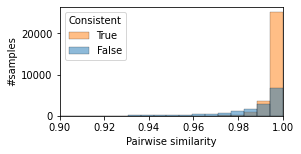

In [5]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=100)
plt.xlim([0.9, 1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(title='Consistent', loc='upper left', labels=['True', 'False'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/sim_cons_any_te_any_obj.svg")
plt.show()

In [6]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.9922016037678018

In [7]:
data[data.pred_type=="any"].pairwise_sim.min()

0.4215492606163025

In [8]:
data[data.pred_type=="any"].pairwise_sim.std()

0.016303083396867445

## Get similarities and corresponding consistency values for pairwise comparisons between the LAMA template and other templates

**Important step:** Remove forbidden predictions to make certain we are only considering fact recall processes.

> Thoughts: Is "works in the field of [digital]" or "works in the field of [human]" ok?

In [9]:
forbidden_predictions = ["a", "the", "collaboration", "response", "public", '"', "order", "partnership", "honor", "AD", "open", "H", "age", "creating", "disgrace", "her", "his", "in", "left", "not", "providing", "tragedy", "which", "whom"]
print("Removing the forbidden predictions for the LAMA paraphrases...")
print(data[data.lama_answer.isin(forbidden_predictions)].lama_answer.value_counts())

forbidden_mask = (data.lama_answer.isin(forbidden_predictions))# | (data.sample_answer.isin(forbidden_predictions))
data = data[~(forbidden_mask)].reset_index(drop=True)
data

Removing the forbidden predictions for the LAMA paraphrases...
the              28327
a                 2814
public             282
response            64
collaboration       32
"                   24
partnership         16
honor               16
order               16
AD                   7
open                 6
H                    5
Name: lama_answer, dtype: int64


,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,Alexandra,False,False,0.023766,0.021967,False,0.998697,4,0,any,P19
1,1,0,Allan Peiper,{} was born in,{} is originally from,London,Canada,Alexandra,False,False,0.017587,0.003975,False,0.995587,4,2,candidate,P19
2,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,Alexandra,False,False,0.023766,0.018423,False,0.998855,4,0,any,P19
3,2,0,Allan Peiper,{} was born in,{} was originally from,London,Canada,Alexandra,False,False,0.017587,0.003594,False,0.996345,4,2,candidate,P19
4,3,0,Allan Peiper,{} was born in,{} is native to,New,the,Alexandra,False,False,0.023766,0.022872,False,0.994816,4,0,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31446,1021,1020,Rumbek,{} is the capital of,{} is the capital city of,Slovenia,Slovenia,Lakes,False,False,0.011378,0.007738,True,0.983722,3,2,candidate,P1376
31447,1022,1020,Rumbek,{} is the capital of,"{}, the capital of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.005172,False,0.996760,3,2,candidate,P1376
31448,1023,1020,Rumbek,{} is the capital of,"{}, the capital city of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.003583,False,0.993998,3,2,candidate,P1376
31449,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.006395,False,0.992868,3,2,candidate,P1376


Check that the remaining predictions are ok...

In [10]:
pd.options.display.max_rows = 4000
print(data.lama_answer.value_counts())#.add(data.sample_answer.value_counts(), fill_value=0).head(1000)

18                3895
London            2464
Japan             1337
France            1198
Paris             1100
Germany           1074
Canada            1048
computer           888
2009               874
India              828
New                714
Chicago            698
Italy              685
Rome               630
Mexico             531
2011               386
Moscow             368
Tokyo              343
Sweden             327
England            305
psychology         300
Poland             298
2012               293
medicine           246
economics          234
2008               211
Berlin             210
2010               198
Denmark            188
17                 178
Brooklyn           168
Israel             168
mathematics        168
Brazil             166
Pakistan           165
Finland            164
Madrid             140
physics            138
digital            138
Norway             136
Iran               136
Greece             136
Australia          131
Russia     

In [11]:
test_token = "the"
data[(data.sample_answer==test_token) | (data.lama_answer==test_token)]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,Alexandra,False,False,0.023766,0.021967,False,0.998697,4,0,any,P19
2,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,Alexandra,False,False,0.023766,0.018423,False,0.998855,4,0,any,P19
4,3,0,Allan Peiper,{} was born in,{} is native to,New,the,Alexandra,False,False,0.023766,0.022872,False,0.994816,4,0,any,P19
6,4,0,Allan Peiper,{} was born in,{} was native to,New,the,Alexandra,False,False,0.023766,0.016975,False,0.996224,4,0,any,P19
8,5,0,Allan Peiper,{} was born in,{} originated from,New,the,Alexandra,False,False,0.023766,0.015993,False,0.983260,4,0,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31144,773,768,Bamako,{} is the capital of,"{}, that is the capital city of",Mali,the,Mali,True,False,0.523068,0.308704,False,0.977363,3,0,any,P1376
31171,793,792,Harrisburg,{} is the capital of,{} is the capital city of,Pennsylvania,the,Pennsylvania,True,False,0.379509,0.357757,False,0.993783,2,0,any,P1376
31336,931,930,Nashville,{} is the capital of,{} is the capital city of,Tennessee,the,Tennessee,True,False,0.476995,0.394561,False,0.980626,3,0,any,P1376
31372,958,954,Saint Paul,{} is the capital of,"{}, that is the capital of",Minnesota,the,Minnesota,True,False,0.427549,0.257020,False,0.989695,2,0,any,P1376


## Similarity values measured before TE thresholding

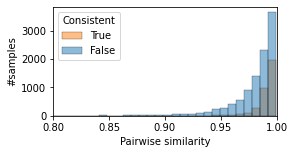

In [12]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=80)
plt.xlim([0.8,1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(title='Consistent', loc='upper left', labels=['True', 'False'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/sim_cons_any_te.svg")
plt.show()

In [13]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.98230348727838

In [14]:
data[data.pred_type=="any"].pairwise_sim.min()

0.4215492606163025

In [15]:
data[data.pred_type=="any"].pairwise_sim.std()

0.026020105593205667

## TE and consistency interaction

For sample TE

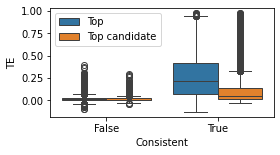

In [16]:
plt.figure(figsize=(4,2))
ax = sns.boxplot(data=data, x="is_consistent", y="sample_te", hue="pred_type")
plt.xlabel("Consistent")
plt.ylabel("TE")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Top", "Top candidate"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_cons.svg")
plt.show()

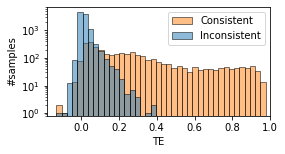

In [17]:
plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[data.pred_type=="any"], x="sample_te", hue="is_consistent", bins=40)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.18,1])
plt.ylim([0.8,0.7e4])
plt.legend(["Consistent", "Inconsistent"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_cons_hist.svg", bbox_inches="tight")
plt.show()

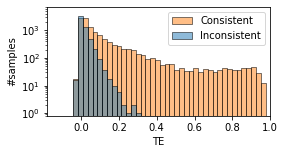

In [18]:
plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[data.pred_type=="candidate"], x="sample_te", hue="is_consistent", bins=40)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.18,1])
plt.ylim([0.8,0.7e4])
plt.legend(["Consistent", "Inconsistent"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_cons_candidate_hist.svg", bbox_inches="tight")
plt.show()

For LAMA TE

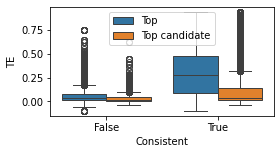

In [19]:
plt.figure(figsize=(4,2))
ax = sns.boxplot(data=data, x="is_consistent", y="lama_te", hue="pred_type")
plt.xlabel("Consistent")
plt.ylabel("TE")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Top", "Top candidate"])
#plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_cons.svg")
plt.show()

In [20]:
data.groupby(["pred_type", "is_consistent"]).sample_te.count()

pred_type  is_consistent
any        False            10463
           True              3445
candidate  False             5692
           True             11851
Name: sample_te, dtype: int64

## TE and accuracy interaction

For top

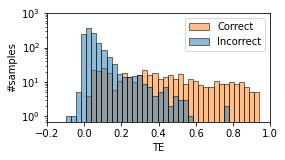

In [21]:
plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct", bins=38)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.2,1])
plt.ylim([0.7, 1000])
#handles, _ = ax.get_legend_handles_labels()
#ax.legend(handles, ["Incorrect", "Correct"])
plt.legend(["Correct", "Incorrect"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_correct.svg", bbox_inches="tight")
plt.show()

In [22]:
len(data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean())

1759

For top candidate and not being top prediction

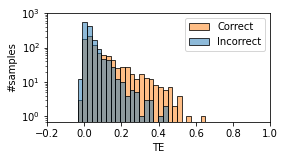

In [23]:
cols_subset = list(data.columns)
cols_subset.remove("pred_type")
cand_dups = data.duplicated(cols_subset)
#need to de-duplicate LAMA template results

plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[~(cand_dups) & (data.pred_type=="candidate")].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct", bins=27)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.2,1])
plt.ylim([0.7, 1000])
#handles, _ = ax.get_legend_handles_labels()
#ax.legend(handles, ["Incorrect", "Correct"])
plt.legend(["Correct", "Incorrect"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_correct_candidate.svg", bbox_inches="tight")
plt.show()

In [24]:
len(data[~(cand_dups) & (data.pred_type=="candidate")].groupby(["lama_ix", "relation"]).mean())

2350

## TE threshold

To ensure that we only measure fact associations for a memory recall process, we restrict our analysis to samples for which perturbing the subject yields a lower probability of the traced object compared to the unperturbed case. I.e. the total effect as defined by Meng et al. is positive.

> We need to be able to show that we can perform causal tracing also for incorrect predictions. The ROME CT results by the ROME authors had a mean TE of 0.229, with minimum around -0.2 and maximum around 1. We match this by thresholding the TE of our CT results to be above 0.1.

In [25]:
te_thresh = 0.1
data = data[(data.sample_te>te_thresh) & (data.lama_te>te_thresh)]
print(f"{len(data)} data samples have a TE above 0.1")

5548 data samples have a TE above 0.1


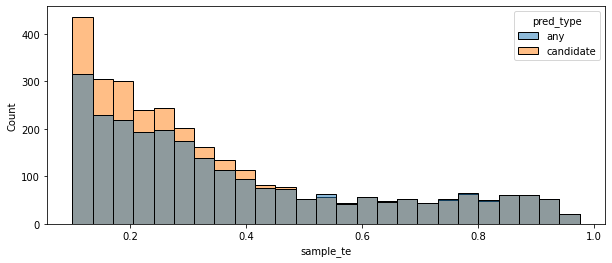

In [26]:
plt.figure(figsize=(10,4))
sns.histplot(data=data, x="sample_te", hue="pred_type")
plt.show()

In [27]:
data.groupby("pred_type")[["sample_te", "lama_te"]].agg(["mean", "count"])

sample_te         lama_te      
               mean count      mean count
pred_type                                
any        0.380810  2544  0.430536  2544
candidate  0.352712  3004  0.375312  3004

In [28]:
data.groupby("pred_type")[["sample_te", "lama_te"]].agg(["mean", "count"])

sample_te         lama_te      
               mean count      mean count
pred_type                                
any        0.380810  2544  0.430536  2544
candidate  0.352712  3004  0.375312  3004

The results for the LAMA template re-occurs for each paraphrase and needs to be de-duplicated.

In [29]:
data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.4007626285231159

In [30]:
data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.35252481416588827

In [31]:
len(data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_te)

620

## The makeup of the data

In [32]:
data[data.pred_type=="any"].relation.value_counts()

P27      1300
P1376     613
P740      389
P19        75
P495       75
P101       50
P20        42
Name: relation, dtype: int64

In [33]:
data[data.pred_type=="candidate"].relation.value_counts()

P27      2135
P1376     708
P495       56
P19        47
P101       29
P740       25
P20         4
Name: relation, dtype: int64

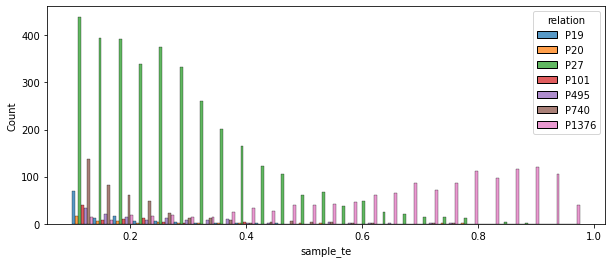

In [34]:
plt.figure(figsize=(10,4))
sns.histplot(data=data, x="sample_te", hue="relation", multiple="dodge")
plt.show()

In [39]:
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_rows', 1000)
data.sort_values(["relation", "subject", "lama_template", "sample_template", "lama_answer"])

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
18302,1322,1316,Aeronautical Information Service,{} works in the field of,{} works in the area of,aviation,aviation,aviation,True,True,0.121244,0.100530,True,0.954417,6,0,any,P101
18303,1322,1316,Aeronautical Information Service,{} works in the field of,{} works in the area of,aviation,aviation,aviation,True,True,0.121244,0.100530,True,0.954417,6,0,candidate,P101
18872,1910,1904,Al-Masudi,{} works in the field of,{} works in the area of,Islamic,Islamic,history,False,False,0.149962,0.114359,True,0.989606,4,0,any,P101
19340,2379,2373,Alfred Kinsey,{} works in the field of,{} works in the area of,sexual,sexual,biology,False,False,0.199905,0.220758,True,0.994416,5,0,any,P101
19466,2491,2485,Australian Mathematical Society,{} works in the field of,{} works in the area of,mathematics,mathematical,mathematics,True,False,0.261399,0.135806,False,0.995289,4,0,any,P101
19467,2491,2485,Australian Mathematical Society,{} works in the field of,{} works in the area of,mathematics,mathematics,mathematics,True,True,0.261399,0.135806,True,0.995289,4,0,candidate,P101
17240,370,364,Charles Darwin,{} works in the field of,{} works in the area of,natural,natural,biology,False,False,0.260806,0.114717,True,0.996740,2,0,any,P101
19754,2799,2793,David Bohm,{} works in the field of,{} works in the area of,quantum,quantum,physics,False,False,0.191636,0.157499,True,0.987774,3,0,any,P101
20036,3079,3073,Edinburgh Mathematical Society,{} works in the field of,{} works in the area of,mathematics,mathematical,mathematics,True,False,0.219180,0.129015,False,0.997691,5,0,any,P101
20037,3079,3073,Edinburgh Mathematical Society,{} works in the field of,{} works in the area of,mathematics,mathematics,mathematics,True,True,0.219180,0.129015,True,0.997691,5,0,candidate,P101


## Consistency results
We are also interested in model consistency. We can here observe how the model is generally more consistent when we filter the output for candidates, but that it does not achieve perfect consistency. 

> Note that these consistency values only are measured for pairwise comparisons between the LAMA template and other paraphrases.

In [35]:
data.groupby("pred_type").is_consistent.agg(["mean", "count"])

,mean,count
pred_type,,
any,0.882075,2544
candidate,0.970373,3004


## Accuracy results
We show that a high TE value can be measured even when the model is not correct. For all results below the TE is higher than 0.1.

In [36]:
data.groupby("pred_type")[["lama_correct", "sample_correct"]].agg(["mean", "count"])

lama_correct       sample_correct      
                  mean count           mean count
pred_type                                        
any           0.683569  2544       0.617531  2544
candidate     0.812250  3004       0.800932  3004

Measure TE and correctness across LAMA templates. Since these are repeated pairwise we need to make sure that we do not double report them.

In [37]:
# number of LAMA queries across all included relations
data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean().lama_correct.count()

526

In [38]:
# number of LAMA queries across all included relations
data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_correct.sum()

485.0

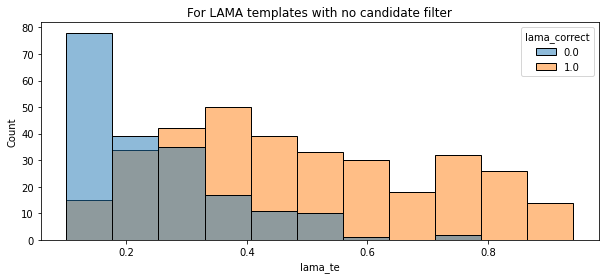

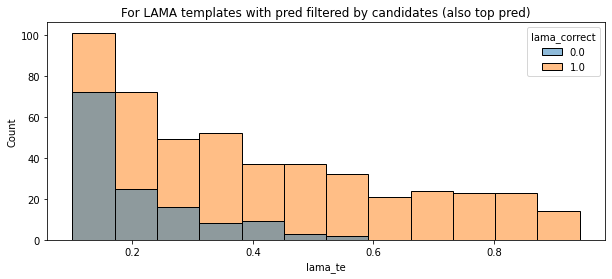

In [39]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct")
plt.title("For LAMA templates with no candidate filter")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct")
plt.title("For LAMA templates with pred filtered by candidates (also top pred)")
plt.show()

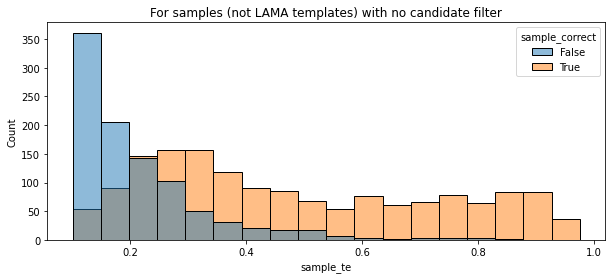

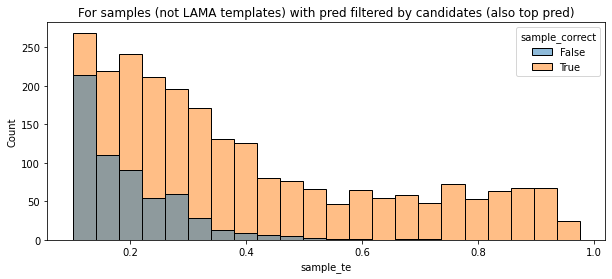

In [40]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"], x="sample_te", hue="sample_correct")
plt.title("For samples (not LAMA templates) with no candidate filter")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"], x="sample_te", hue="sample_correct")
plt.title("For samples (not LAMA templates) with pred filtered by candidates (also top pred)")
plt.show()

In [41]:
cols_subset = list(data.columns)
cols_subset.remove("pred_type")
cand_dups = data.duplicated(cols_subset)
#need to de-duplicate LAMA template results
data[~(cand_dups) & (data.pred_type=="candidate")].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.21812908259359584

## Evaluate RQ1

We should be able to observe a correlation between consistent predictions and consistent fact recall, measured as similarity between extracted factual subject associations. 

We report the Spearman correlation between model consistency and extraction pattern similarity.

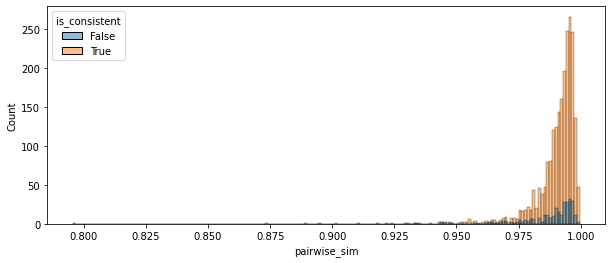

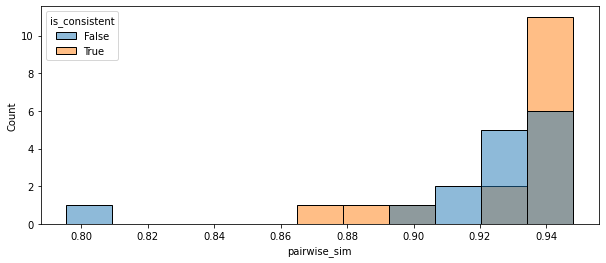

In [42]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[(data.pred_type=="any") & (data.pairwise_sim<0.95)], x="pairwise_sim", hue="is_consistent")
plt.show()

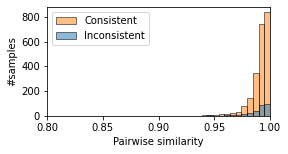

In [49]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=40)
plt.xlim([0.8,1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(loc='upper left', labels=['Consistent', 'Inconsistent'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/sim_cons.svg", bbox_inches="tight")
plt.show()

In [45]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.9899187574278564

In [46]:
data[data.pred_type=="any"].pairwise_sim.min()

0.7954744696617126

In [47]:
data[data.pred_type=="any"].pairwise_sim.std()

0.010807136358184472

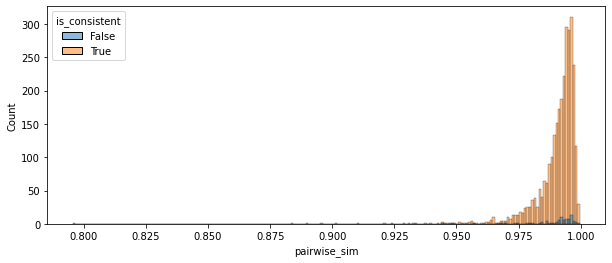

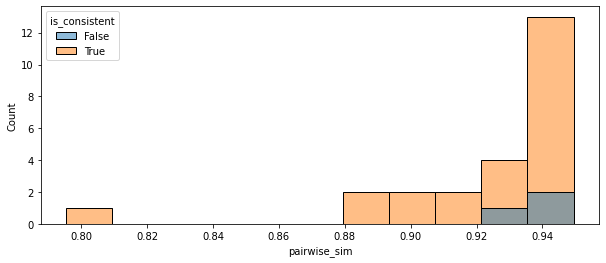

In [48]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"], x="pairwise_sim", hue="is_consistent")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[(data.pred_type=="candidate") & (data.pairwise_sim<0.95)], x="pairwise_sim", hue="is_consistent")
plt.show()

In [49]:
test_data = data[data.pred_type=="any"].copy()

print(scipy.stats.spearmanr(test_data.is_consistent, 
                      test_data.pairwise_sim))
print(f"Number of samples: {len(test_data)}, of which {(len(test_data[test_data.is_consistent]))} are consistent.")

SpearmanrResult(correlation=0.08910103862460196, pvalue=6.768837343329743e-06)
Number of samples: 2544, of which 2244 are consistent.


In [50]:
test_data = data[data.pred_type=="candidate"].copy()

print(scipy.stats.spearmanr(test_data.is_consistent, 
                      test_data.pairwise_sim))
print(f"Number of samples: {len(test_data)}, of which {(len(test_data[test_data.is_consistent]))} are consistent.")

SpearmanrResult(correlation=0.01009404431072145, pvalue=0.580245696243056)
Number of samples: 3004, of which 2915 are consistent.


## Error analysis

In [153]:
data[data.is_consistent==False].groupby(["lama_answer","sample_answer"]).agg({"lama_te": "mean", "sample_te": "mean", "pairwise_sim": ["mean","count"]})


lama_te sample_te pairwise_sim      
                                mean      mean         mean count
lama_answer  sample_answer                                       
16           the            0.168044  0.143184     0.980341     5
17           18             0.242252  0.137868     0.969184     4
             the            0.366422  0.130206     0.986570     7
18           17             0.162963  0.140556     0.994763     1
             Germany        0.238515  0.103195     0.966337     1
             London         0.500827  0.107230     0.963326     1
             the            0.229356  0.120221     0.986925    22
1886         Atlanta        0.580939  0.153095     0.986522     2
1922         the            0.150124  0.100408     0.944875     1
1954         the            0.435695  0.139915     0.964517     2
1963         the            0.756053  0.161902     0.933813     1
1979         the            0.146299  0.107975     0.995438     1
1991         the            0.170852  0.116143     0.993882     1
1993         a              0.228004  0.135091     0.992047     1
1994         2002           0.108823  0.125583     0.998502     1
6            the            0.143021  0.109505     0.994711     1
Athens       the            0.195073  0.114265     0.917919     3
Bangladesh   Pakistan       0.272734  0.163217     0.981830    22
Canada       Ontario        0.520520  0.206600     0.987877    10
             the            0.408772  0.114220     0.985126     1
Denmark      Norway         0.164878  0.121129     0.995542    10
             the            0.288427  0.138748     0.995001     1
Finland      the            0.346576  0.137302     0.978889     1
Finnish      the            0.346656  0.173593     0.985442     1
France       Belgium        0.145817  0.105819     0.996155     2
             Canada         0.244773  0.130775     0.991769    17
             the            0.332355  0.166359     0.992956    22
Frankfurt    the            0.294775  0.153518     0.921426     1
Germany      the            0.269244  0.165724     0.990818     3
Greece       the            0.407630  0.191552     0.985688     5
Gujarat      the            0.239702  0.179152     0.995139     2
Hong         the            0.123169  0.111268     0.968984     2
India        Pakistan       0.212710  0.132403     0.993216    11
             the            0.317415  0.114382     0.992025    11
Iran         Iraq           0.200611  0.158406     0.992721     1
             Israel         0.240806  0.109825     0.988907     5
             the            0.268269  0.134527     0.993649     5
Ireland      Canada         0.135938  0.155638     0.986828     1
             the            0.385666  0.190337     0.990475     9
Israel       the            0.511312  0.214233     0.993124     1
Italy        the            0.247560  0.128063     0.992946     7
Japan        the            0.352235  0.165179     0.993702    31
Kenya        the            0.165398  0.118527     0.987003     2
Latvia       the            0.232415  0.112548     0.988616     4
Malaysia     the            0.267361  0.201805     0.988771     1
Mali         the            0.371858  0.216476     0.987320     5
Mexico       Spain          0.222431  0.116017     0.992383     4
             the            0.225782  0.185374     0.987289     1
Minnesota    the            0.427549  0.257745     0.991150     2
Montreal     Quebec         0.181158  0.109099     0.948578     2
             Toronto        0.223077  0.100962     0.984288     2
             the            0.146406  0.105398     0.970391     1
Moscow       Russia         0.127078  0.124212     0.973934     3
             St             0.140879  0.117879     0.977650     2
             the            0.128075  0.112778     0.948904     6
Nepal        India          0.151695  0.134798     0.971061     2
Nigeria      the            0.222385  0.127938     0.990749     2
Norway       Denmark        0.260215  0.169523     0.993414     3
   

Is it the case that the model for "the" or "a" sample predictions also ranks the LAMA predicted token highly?

In [154]:
the_ixs = data[(data.is_consistent==False) & (data.sample_answer.isin(forbidden_predictions))][["relation","sample_ix"]]
data_mask = data.apply(lambda row: row.sample_ix in list(the_ixs[the_ixs.relation==row.relation].sample_ix), axis=1)
data[data_mask]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,pred_type,relation
598,472,469,Jack Wong Sue,{} was born in,{} is native to,Hong,the,Perth,False,False,0.123169,0.110391,False,0.969623,any,P19
600,473,469,Jack Wong Sue,{} was born in,{} was native to,Hong,the,Perth,False,False,0.123169,0.112146,False,0.968345,any,P19
1458,1152,1148,Sergey Lavrov,{} was born in,{} was native to,Moscow,the,Moscow,True,False,0.140879,0.110098,False,0.963229,any,P19
1459,1152,1148,Sergey Lavrov,{} was born in,{} was native to,Moscow,Moscow,Moscow,True,True,0.140879,0.110098,True,0.963229,candidate,P19
1460,1153,1148,Sergey Lavrov,{} was born in,{} originated from,Moscow,the,Moscow,True,False,0.140879,0.114179,False,0.952366,any,P19
1461,1153,1148,Sergey Lavrov,{} was born in,{} originated from,Moscow,Moscow,Moscow,True,True,0.140879,0.114179,True,0.952366,candidate,P19
1462,1154,1148,Sergey Lavrov,{} was born in,{} originates from,Moscow,the,Moscow,True,False,0.140879,0.122286,False,0.975845,any,P19
1463,1154,1148,Sergey Lavrov,{} was born in,{} originates from,Moscow,Moscow,Moscow,True,True,0.140879,0.122286,True,0.975845,candidate,P19
1826,1433,1428,Marek Borowski,{} was born in,{} originated from,Poland,the,Warsaw,False,False,0.107024,0.108890,False,0.974609,any,P19
1828,1434,1428,Marek Borowski,{} was born in,{} originates from,Poland,the,Warsaw,False,False,0.107024,0.123164,False,0.989463,any,P19


In [155]:
data[(data.is_consistent==True) & (data.pairwise_sim<0.95)].groupby(["lama_answer","sample_answer"]).agg({"lama_te": "mean", "sample_te": "mean", "pairwise_sim": ["mean","count"]})


lama_te sample_te pairwise_sim      
                               mean      mean         mean count
lama_answer sample_answer                                       
12          12             0.208139  0.176591     0.942730     1
16          16             0.214494  0.251021     0.947381     1
18          18             0.215112  0.149558     0.927302     5
1963        1963           0.756053  0.552662     0.947120     1
Alaska      Alaska         0.422798  0.816700     0.945042     1
Athens      Athens         0.110305  0.101537     0.795474     1
Bangladesh  Bangladesh     0.228723  0.308852     0.946472     2
France      France         0.174894  0.210762     0.914410     5
Frankfurt   Frankfurt      0.294775  0.216067     0.900264     3
Greece      Greece         0.274748  0.368712     0.944373     6
Italy       Italy          0.161020  0.336936     0.949214     2
Japan       Japan          0.102984  0.131535     0.944208     1
Montreal    Montreal       0.209104  0.157972     0.931584     3
Moscow      Moscow         0.127078  0.121854     0.922870     3
Syria       Syria          0.102314  0.142227     0.939832     1
genetics    genetics       0.651296  0.102706     0.910494     1
history     history        0.255976  0.110708     0.947296     1
poetry      poetry         0.315096  0.263122     0.934101     2

In [53]:
data[data.subject=="Bertil Lindblad"]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
9772,36,35,Bertil Lindblad,{} is a citizen of,"{}, a citizen of",Sweden,Norway,Sweden,True,False,0.224657,0.178135,False,0.991227,6,0,any,P27
9773,36,35,Bertil Lindblad,{} is a citizen of,"{}, a citizen of",Sweden,Norway,Sweden,True,False,0.224657,0.178135,False,0.991227,6,0,candidate,P27
9774,37,35,Bertil Lindblad,{} is a citizen of,"{}, who is a citizen of",Sweden,Sweden,Sweden,True,True,0.224657,0.257637,True,0.990541,6,0,any,P27
9775,37,35,Bertil Lindblad,{} is a citizen of,"{}, who is a citizen of",Sweden,Sweden,Sweden,True,True,0.224657,0.257637,True,0.990541,6,0,candidate,P27
9776,38,35,Bertil Lindblad,{} is a citizen of,{} holds a citizenship of,Sweden,the,Sweden,True,False,0.224657,0.151713,False,0.995319,6,0,any,P27
9777,38,35,Bertil Lindblad,{} is a citizen of,{} holds a citizenship of,Sweden,Norway,Sweden,True,False,0.224657,0.151713,False,0.995319,6,0,candidate,P27
9778,39,35,Bertil Lindblad,{} is a citizen of,{} has a citizenship of,Sweden,Sweden,Sweden,True,True,0.224657,0.178748,True,0.992143,6,0,any,P27
9779,39,35,Bertil Lindblad,{} is a citizen of,{} has a citizenship of,Sweden,Sweden,Sweden,True,True,0.224657,0.178748,True,0.992143,6,0,candidate,P27
9780,40,35,Bertil Lindblad,{} is a citizen of,"{}, who holds a citizenship of",Sweden,Sweden,Sweden,True,True,0.224657,0.202031,True,0.991397,6,0,any,P27
9781,40,35,Bertil Lindblad,{} is a citizen of,"{}, who holds a citizenship of",Sweden,Sweden,Sweden,True,True,0.224657,0.202031,True,0.991397,6,0,candidate,P27
